This script is developed based on 'KProject_HousePrice_i5'

### Outline:
0. Load libraries and custom functions.
1. Load data.
2. Preliminary data analysis: explore features and a target, delete unneeded features, create new features.
3. Train-test split.
4. Missing values. In some cases it may be useful to explore skew and perform log-transform before imputing missing values.
5. Feature engineering. Transform skewed variables, do OHC and scaling.
6. Fit models.
7. Evaluate models.
8. Feature importance, error analysis. Based on the results, go to 2. and iterate.
9. Make predictions.

In [1]:
# 0. Load libraries #

import numpy as np
import pandas as pd
import os, time, warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, r2_score
from sklearn.inspection import permutation_importance
from scipy.special import inv_boxcox
from xgboost import XGBClassifier, XGBRegressor

pd.set_option('display.max_columns', 20)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()


def fillna_mp_i1(df_train, df_test, df_pred, num_features, cat_features, num_fill='median', cat_fill='mode'):
    """This function speeds up filling missing values for 3 main datasets using different imputation methods.
    Later may replace it with some subclass.
    Example: fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)"""
    # set df_pred to None if it does not exist
    if (cat_fill=='mode'):
    
        df_train[cat_features] = df_train[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
        df_test[cat_features] = df_test[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
        if (df_pred is not None):
            df_pred[cat_features] = df_pred[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
            
    if (cat_fill=='missing'):
    
        df_train[cat_features] = df_train[cat_features].fillna(value='missing')
        df_test[cat_features] = df_test[cat_features].fillna(value='missing')
        if (df_pred is not None):
            df_pred[cat_features] = df_pred[cat_features].fillna(value='missing')
        
    if (num_fill=='median'):
        df_train[num_features] = df_train[num_features].fillna(value=df_train[num_features].median())
        df_test[num_features] = df_test[num_features].fillna(value=df_train[num_features].median())
        if (df_pred is not None):
            df_pred[num_features] = df_pred[num_features].fillna(value=df_train[num_features].median())    
    
    all_good = (
    (np.prod(df_train[num_features+cat_features].shape)==df_train[num_features+cat_features].count().sum()) and 
    (np.prod(df_test[num_features+cat_features].shape) == df_test[num_features+cat_features].count().sum()) and 
    (np.prod(df_pred[num_features+cat_features].shape) == df_pred[num_features+cat_features].count().sum()))
    if (all_good):
        print('Missing values imputed successfully')
    else:
        print('There are still some missing values...')
    
    
    
def add_misDummy_mp_i1(df_train, df_test, df_pred, features):
    """This function creates new dummy columns for missing features.
    Example: add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])"""
    # set df_pred to None if it does not exist
    for feature_name in features:
        misColName = 'mis'+feature_name
        df_train.loc[df_train[feature_name].isnull(), misColName]=1
        df_train.loc[df_train[feature_name].notnull(), misColName]=0
        df_test.loc[df_test[feature_name].isnull(), misColName]=1
        df_test.loc[df_test[feature_name].notnull(), misColName]=0
        if (df_pred is not None):
            df_pred.loc[df_pred[feature_name].isnull(), misColName]=1
            df_pred.loc[df_pred[feature_name].notnull(), misColName]=0
   

def discretize_mp_i1(df_train, df_test, df_pred, feature, ntiles, delete_feature=False):
    """This function divides a continuous feature into quantile groups.
    Example: discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)"""
    # set df_pred to None if it does not exist
    _,bin = pd.qcut(df_train[feature], ntiles, retbins = True, labels = False, duplicates = 'drop')
    df_train[feature+'Ntile'] = pd.cut(df_train[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    df_test[feature+'Ntile'] = pd.cut(df_test[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (df_pred is not None):
        df_pred[feature+'Ntile'] = pd.cut(df_pred[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (delete_feature==True):
        df_train.drop(columns=[feature], inplace=True)
        df_test.drop(columns=[feature], inplace=True)
        df_pred.drop(columns=[feature], inplace=True)
    print('Discretized ',feature, ' into ', len(bin)-1, ' bins')


def log_transformer_mp_i1(df_train, df_test, df_pred, feature_subset=False, min_skew=3):
    """This function divides a continuous feature into quantile groups.
    Example: log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)"""
    # set df_pred to None if it does not exist
    if (feature_subset==False):
        features_totransform = df_train.columns
    else:
        features_totransform = feature_subset.copy()
    skewed_vars = list(df_train.skew()[abs(df_train.skew())>min_skew].index)
    for col in list(set(skewed_vars)&set(features_totransform)):
        df_train[col] = np.log1p(df_train[col])
        df_test[col] = np.log1p(df_test[col])
        if (df_pred is not None):
            df_pred[col] = np.log1p(df_pred[col])
    print('Skewed columns log-transformed: ', list(set(skewed_vars)&set(features_totransform)))
    
    
def add_dummyfeatures(df_train, df_test, df_pred, feature_dict):
    """This function adds dummy feature when some feature is equal to value, specified in a dictionary.
    Example: add_dummyfeatures(X_train, X_test, X_pred, {'RoomService':0, 'Spa':0, 'VRDeck':0, 'ShoppingMall':0})"""
    input_dimensions = np.array([df_train.shape[1], df_test.shape[1], df_pred.shape[1]])
    for i in range(len(list(feature_dict.items()))):
        feature,value = list(feature_dict.keys())[i], list(feature_dict.values())[i]
        df_train.loc[df_train[feature]==value,(str(feature)+str(value))]=1
        df_train.loc[df_train[feature]!=value,(str(feature)+str(value))]=0
        df_test.loc[df_test[feature]==value,(str(feature)+str(value))]=1
        df_test.loc[df_test[feature]!=value,(str(feature)+str(value))]=0
        df_pred.loc[df_pred[feature]==value,(str(feature)+str(value))]=1
        df_pred.loc[df_pred[feature]!=value,(str(feature)+str(value))]=0
    output_dimensions = np.array([df_train.shape[1], df_test.shape[1], df_pred.shape[1]])
    print(output_dimensions-input_dimensions, ' variables created') 
    
    

In [51]:
# 1. Load data #

time0 = time.time()
path = '../input/house-prices-advanced-regression-techniques/train.csv'
df = pd.read_csv(path) 
df0 = df.copy()

pred=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
pred0 = pred.copy()

print(df.shape, pred.shape)
df

# 2. pEDA #

cols_tokeep = ['Id', 'SalePrice', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterCond', 
               'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',  
               'KitchenQual', 'GarageArea', 'GarageCars', 'TotRmsAbvGrd', 'BedroomAbvGr', 'FullBath', 
               'HalfBath', 'MiscVal', 'LotFrontage', 
               'ExterQual', 'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
               'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
               'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'PavedDrive',
               'SaleType', 'SaleCondition', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 
               'BsmtExposure', 'BsmtFinType1', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df = df[cols_tokeep]
X_pred = pred[list(set(cols_tokeep) - set(['SalePrice']))]

# preliminary feature engineering:
df['GrLivArea'] = np.log1p(df['GrLivArea'])
X_pred['GrLivArea'] = np.log1p(X_pred['GrLivArea'])
# w/o logtransform, scatterplot looks better. not sure whether log tranform helps.


# 3. train-test split #

train_y = df['SalePrice']
train_x = df.drop(columns = ['SalePrice'])

ord_cols = ['ExterCond', 'HeatingQC', 'KitchenQual', 'ExterQual', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond']
#num_cols = [col for col in train_x.columns if train_x[col].nunique() > 12]
num_cols = ['Id', 'LotArea', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
            'GrLivArea', 'GarageArea', 'MiscVal', 'LotFrontage', 'MasVnrArea',
           'TotRmsAbvGrd', 'GarageCars', 'BedroomAbvGr', 'OverallCond', 'OverallQual']
cat_cols = list(set(train_x.columns)-set(num_cols))
# for now, view ordinal features as categorical features
print("Numerical features ", num_cols, "\n",
      "Categorical features ", cat_cols)

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=5)
print(X_train.shape, X_test.shape, y_train.shape, X_pred.shape)

# 4. Missing values #

fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols, num_fill = 'median', cat_fill='missing')

# 5. Feature engineering #

# add dummy features
add_dummyfeatures(X_train, X_test, X_pred, {'OverallQual':1, 'OverallQual':8, 'OverallQual':9, 'OverallQual':10})

log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)

feature_transformer = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_cols),
    ])

X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_pred = pd.DataFrame(feature_transformer.transform(X_pred), columns=feature_transformer.get_feature_names_out())

# there are many dummies... may wish to use pca here later.

# 6. Model Fitting #

lr = LinearRegression()
lr.fit(X_train, y_train)
print('OLS ', r2_score(y_train, lr.predict(X_train)))

time1 = time.time()
rd = Ridge()
grid_param = {'alpha': [10, 20, 30, 50, 100, 200]}
rdm = GridSearchCV(rd, grid_param, cv=8)
rdm.fit(X_train, y_train)
print('Ridge ', rdm.best_params_, rdm.best_score_, r2_score(y_train, rdm.predict(X_train)), time.time()-time1)


time1 = time.time()
svr = SVR()
grid_param = {'C': [200000, 300000, 500000]}
svrm = GridSearchCV(svr, grid_param, cv=4)
svrm.fit(X_train, y_train)
print('SVR ', svrm.best_params_, svrm.best_score_, r2_score(y_train, svrm.predict(X_train)), time.time()-time1)

time1 = time.time()
xgb = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
grid_param = {'n_estimators':[200], 'max_depth':[2,3,4], 'eta':[0.15, 0.2, 0.25]}
xgbm = GridSearchCV(xgb, grid_param, cv=4)
xgbm.fit(X_train, y_train)
print('XGB ', xgbm.best_params_, xgbm.best_score_, r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

# 7. Model Evaluation #

print('Ridge ', r2_score(y_test, rdm.predict(X_test)))
print('SVR ', r2_score(y_test, svrm.predict(X_test)))
print('XGB ', r2_score(y_test, xgbm.predict(X_test)))
# sometimes ridge may fail really bad.
print('Total Time is ', time.time()-time0)

(1460, 81) (1459, 80)
Numerical features  ['Id', 'LotArea', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'MiscVal', 'LotFrontage', 'MasVnrArea', 'TotRmsAbvGrd', 'GarageCars', 'BedroomAbvGr', 'OverallCond', 'OverallQual'] 
 Categorical features  ['GarageQual', 'Functional', 'Neighborhood', 'SaleType', 'LotConfig', 'RoofStyle', 'Electrical', 'Foundation', 'Exterior2nd', 'BldgType', 'HeatingQC', 'GarageType', 'KitchenQual', 'MSZoning', 'SaleCondition', 'HouseStyle', 'BsmtCond', 'LandContour', 'Heating', 'BsmtFinType1', 'FullBath', 'BsmtQual', 'MSSubClass', 'BsmtExposure', 'ExterQual', 'ExterCond', 'Exterior1st', 'MasVnrType', 'Condition1', 'GarageCond', 'CentralAir', 'LotShape', 'PavedDrive', 'HalfBath', 'GarageFinish']
(1168, 53) (292, 53) (1168,) (1459, 53)
Missing values imputed successfully
[1 1 1]  variables created
Skewed columns log-transformed:  ['BsmtFinSF2', 'LotArea', 'MiscVal']
OLS  0.902979047829197
Ridge  {'alpha'

In [52]:
# 8. Feature importance #

results = permutation_importance(xgbm, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results.importances_mean})
fi = fi.sort_values('FI', ascending = False)
fi
# OverallQual and GrLivArea ate the two most important features

,col,FI
17,num__OverallQual,0.252473
8,num__GrLivArea,0.123048
5,num__TotalBsmtSF,0.035928
3,num__BsmtFinSF1,0.028432
14,num__GarageCars,0.026763
...,...,...
143,cat__BsmtCond_Gd,-0.000482
93,cat__Exterior2nd_HdBoard,-0.000747
208,cat__Exterior1st_HdBoard,-0.000964
189,cat__BsmtExposure_Gd,-0.001321


In [47]:
att1 = fi[fi.FI<0]

In [50]:
att2 = fi[fi.FI<0]

In [53]:
att3 = fi[fi.FI<0]

In [66]:
fi.iloc[150:220,]

,col,FI
61,cat__SaleType_ConLw,0.000000
41,cat__Neighborhood_MeadowV,0.000000
101,cat__Exterior2nd_Wd Shng,0.000000
98,cat__Exterior2nd_Stucco,0.000000
44,cat__Neighborhood_NPkVill,0.000000
...,...,...
142,cat__BsmtCond_Fa,-0.000008
49,cat__Neighborhood_SWISU,-0.000011
215,cat__Exterior1st_Wd Sdng,-0.000012
76,cat__Electrical_FuseA,-0.000013


In [ ]:
set(att3.col) & set(att2.col) & set(att1.col)

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

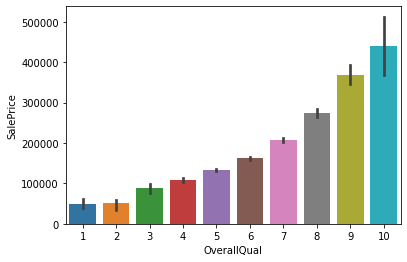

In [80]:
sns.barplot(data=df, x='OverallQual', y='SalePrice')

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

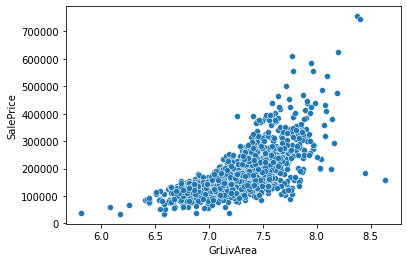

In [32]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')
# transformed

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

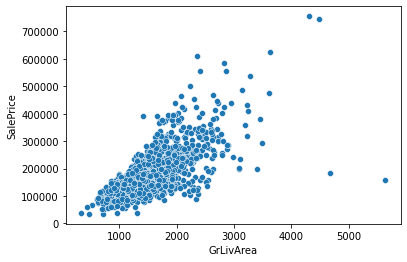

In [34]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')
# not transformed

In [57]:
train_x[['OverallQual', 'GrLivArea']].skew()

OverallQual    0.216944
GrLivArea     -0.006140
dtype: float64

array([[<AxesSubplot:title={'center':'GrLivArea'}>]], dtype=object)

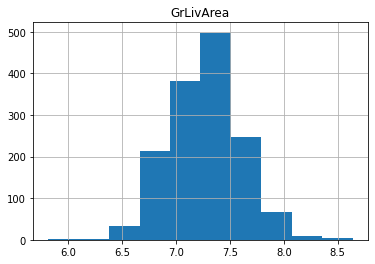

In [58]:
train_x[['GrLivArea']].hist()